In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Data/processed.csv')
df.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,year,month,day,hour,cluster
0,2022-01-01,11.021500,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,2022,1,1,0,4
1,2022-01-01,10.521500,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,2022,1,1,1,4
2,2022-01-01,10.721499,96.0,8.677092,0.0,0.0,0.0,0.0,1019.8,1018.69610,100.0,14.345898,197.52567,39.96,0.0,2022,1,1,2,4
3,2022-01-01,11.071500,97.0,9.138726,0.0,0.0,0.0,0.0,1019.7,1018.59784,100.0,14.587776,195.75124,42.12,0.0,2022,1,1,3,4
4,2022-01-01,11.221499,96.0,8.969191,0.0,0.0,0.0,0.0,1019.5,1018.39825,100.0,16.766108,194.93147,49.32,0.0,2022,1,1,4,4


In [4]:
df.isna().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
apparent_temperature    0
precipitation           0
rain                    0
showers                 0
snowfall                0
pressure_msl            0
surface_pressure        0
cloud_cover             0
wind_speed_10m          0
wind_direction_10m      0
wind_gusts_10m          0
is_day                  0
year                    0
month                   0
day                     0
hour                    0
cluster                 0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

### EDA

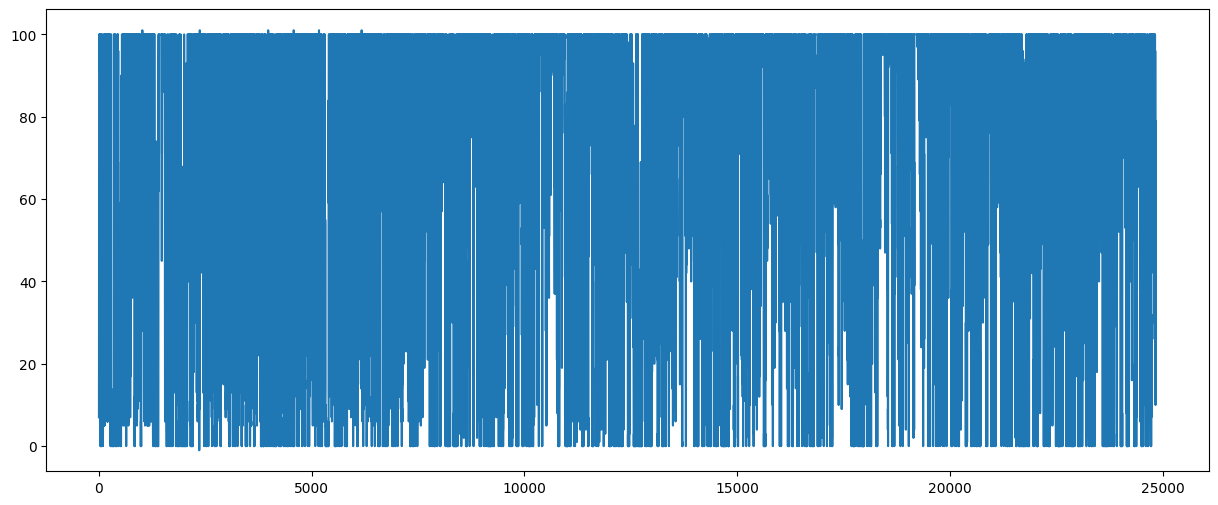

In [6]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['cloud_cover'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

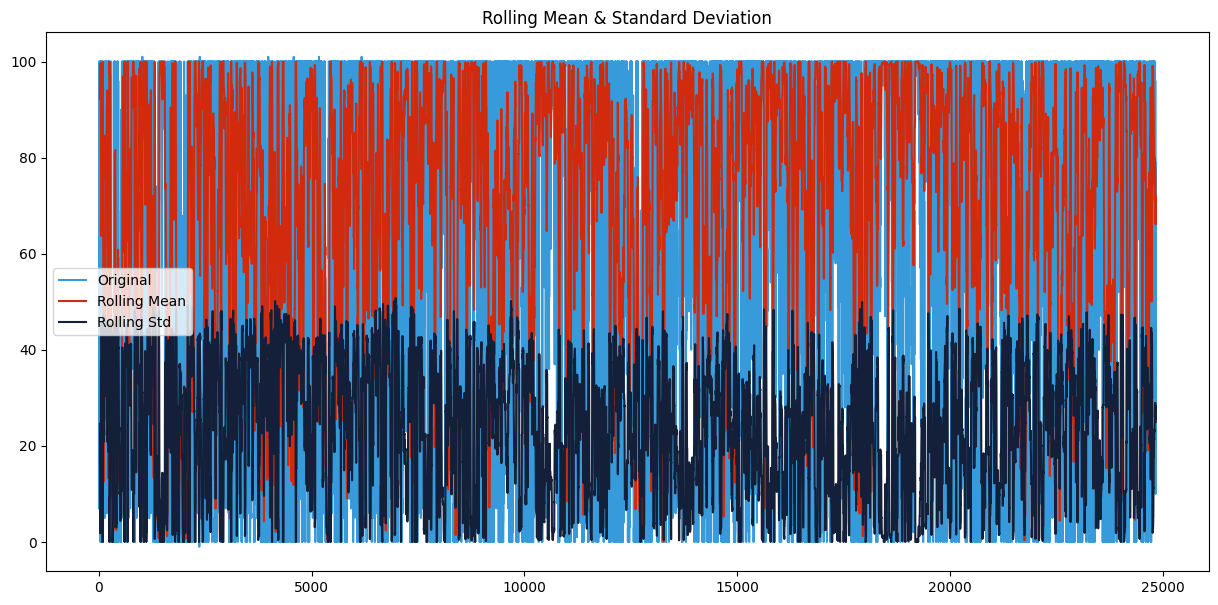

In [7]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["cloud_cover"], color='#379BDB', label='Original')
plt.plot(df["cloud_cover"].rolling(window=24).mean(), color='#D22A0D', label='Rolling Mean')
plt.plot(df["cloud_cover"].rolling(window=24).std(), color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

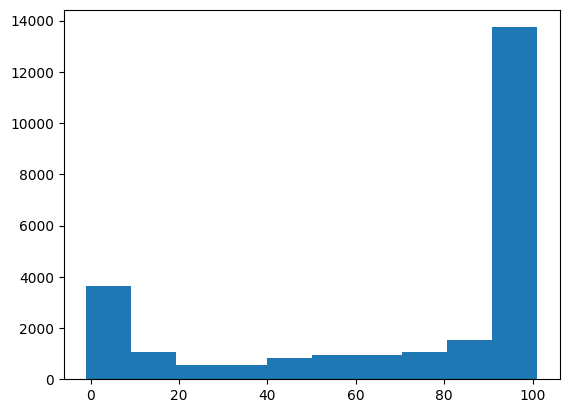

In [8]:
plt.hist(df['cloud_cover'])
plt.show()

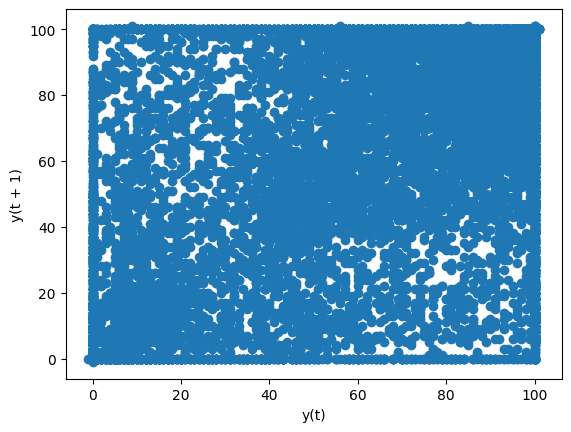

In [9]:
from pandas.plotting import lag_plot

lag_plot(df['cloud_cover'])
plt.show()

In [10]:
# Checking auto-correlation
from pandas import concat

btc_price = df['cloud_cover']
dataframe = concat([btc_price.shift(1), btc_price], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
result

,t,t+1
t,1.000000,0.785234
t+1,0.785234,1.000000


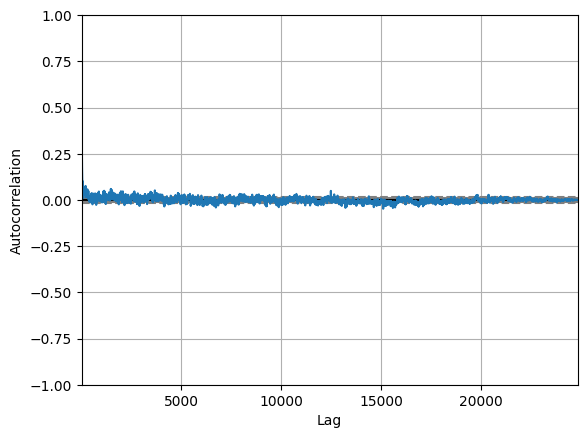

In [11]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['cloud_cover'])
plt.show()

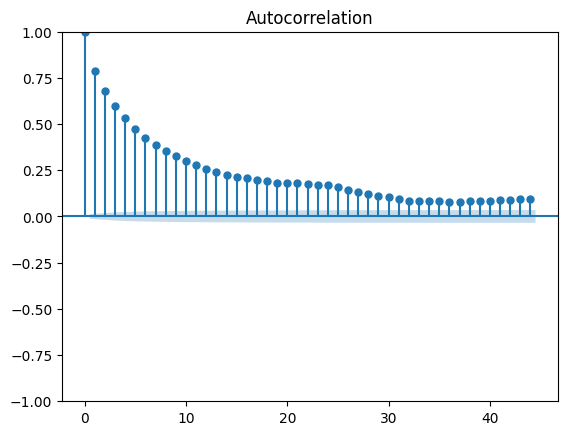

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['cloud_cover'])
plt.show()

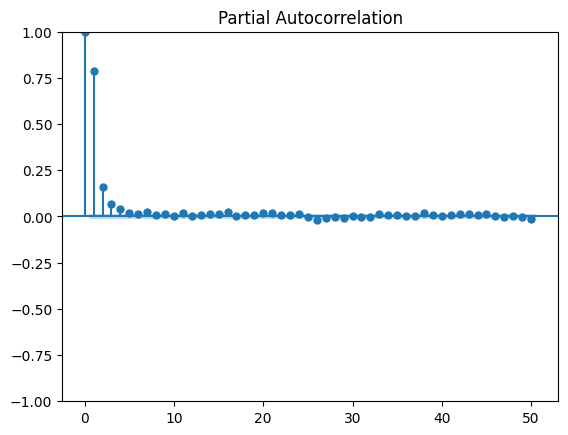

In [13]:
plot_pacf(df['cloud_cover'], lags=50)
plt.show()

### Data transformation

In [14]:
df = df.drop(['year', 'date'], axis = 1)
df.head(2)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster
0,11.0215,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,1,1,0,4
1,10.5215,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,1,1,1,4


<Axes: >

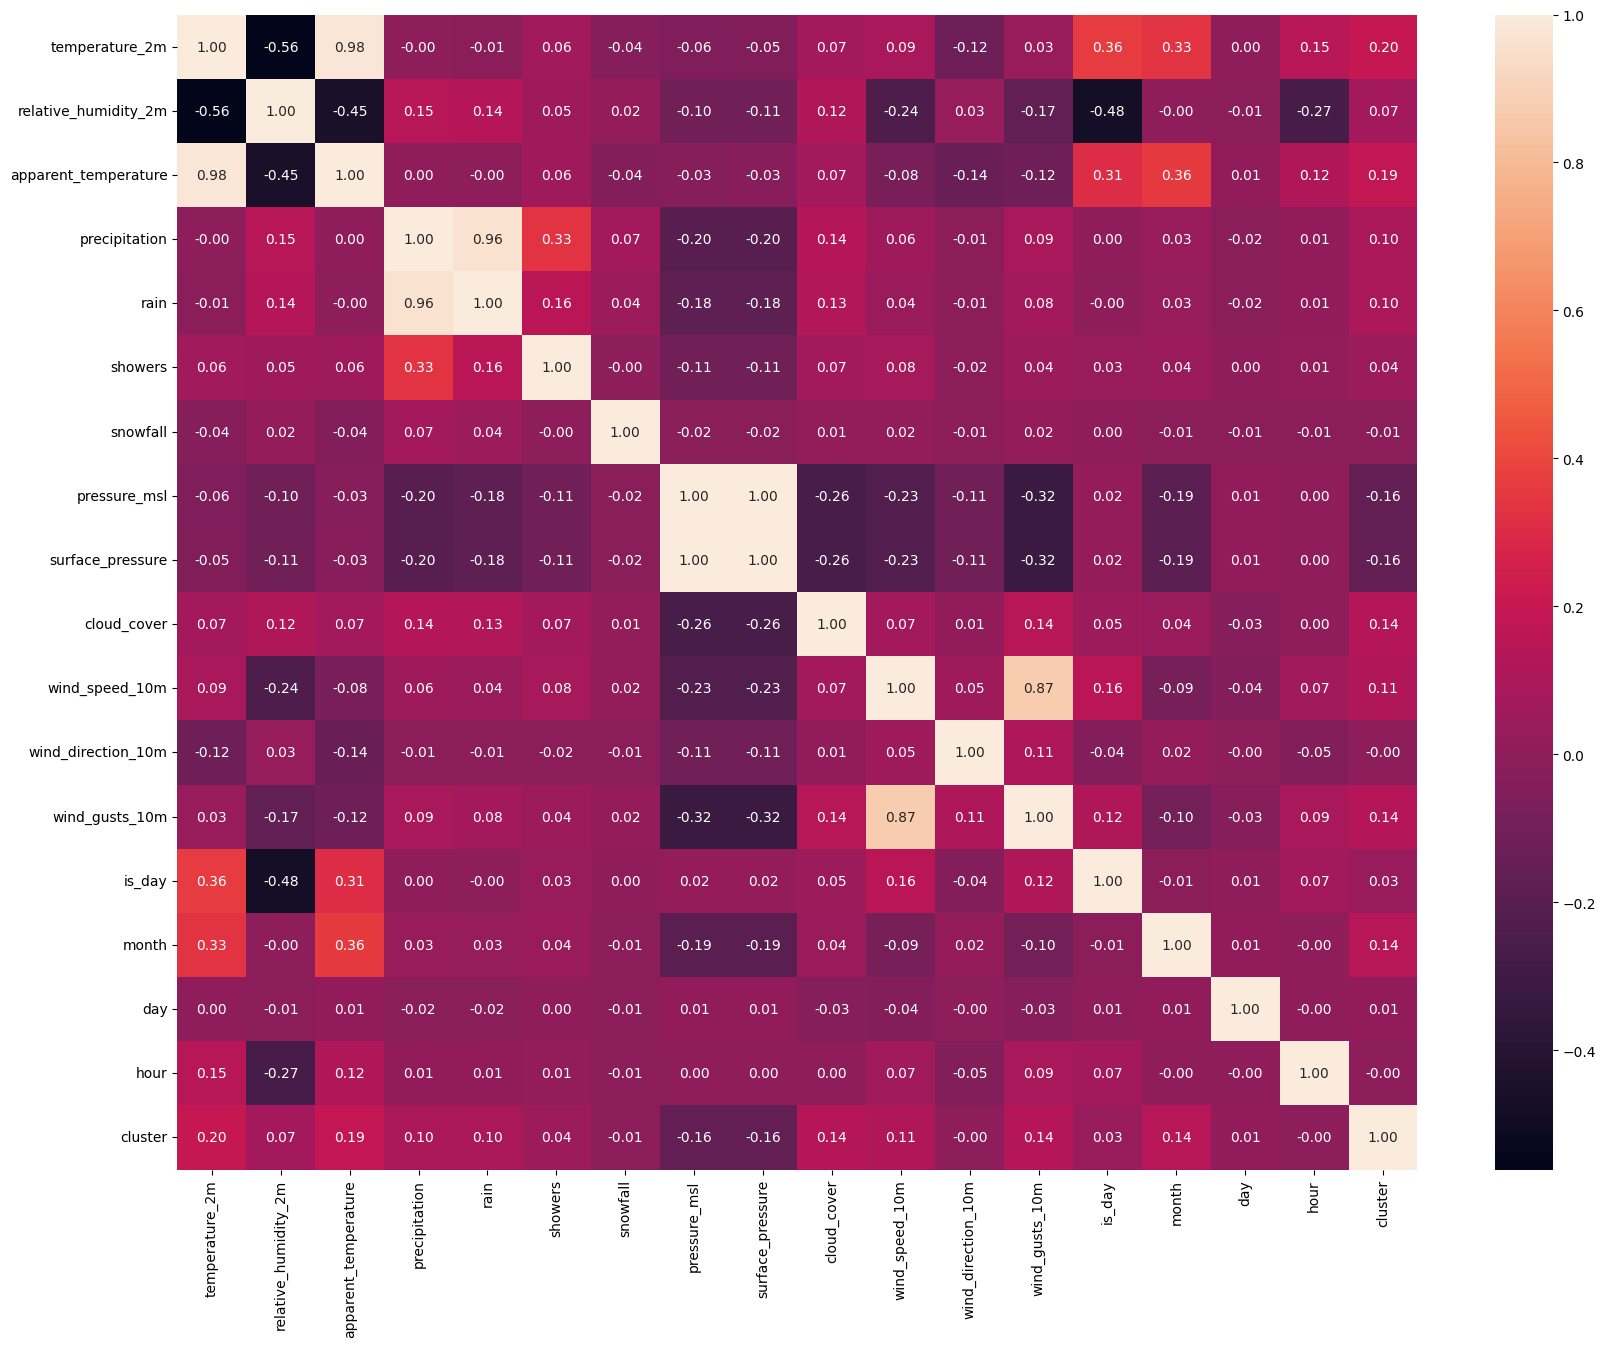

In [15]:
# Create correlation matrix heat map to check multi-collinearity between columns.

plt.figure(figsize = (20,15), dpi = 100)
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

### Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cloud_cover'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -21.321011641915327
p-value: 0.0


### Data Splitting and scaling

In [17]:
len(df.index) - (len(df.index) * 20 /100)

19872.0

In [18]:
train = df.iloc[:19872]
test = df.iloc[19872:]
test.reset_index(drop = True, inplace = True)

In [19]:
x_train = train.drop('cloud_cover', axis = 1)
y_train = train[['cloud_cover']]
x_test = test.drop('cloud_cover', axis = 1)
y_test = test[['cloud_cover']]

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19872, 17)
(19872, 1)
(4968, 17)
(4968, 1)


### Feature Selection

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the features
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [22]:
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(x_train, y_train)

c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.054208762192502, tolerance: 1.4419206834418408
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.68826647552669, tolerance: 1.4419206834418408
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\l

LassoCV(cv=5, random_state=42)

In [23]:
# Get the coefficients
feature_names = list(train.columns)
feature_names.remove('cloud_cover')
lasso_coefficients = lasso.coef_

# Identify selected features
selected_features_indices = np.where(lasso_coefficients != 0)[0]
selected_feature_names = [feature_names[i] for i in selected_features_indices]
selected_coefficients = lasso_coefficients[selected_features_indices]

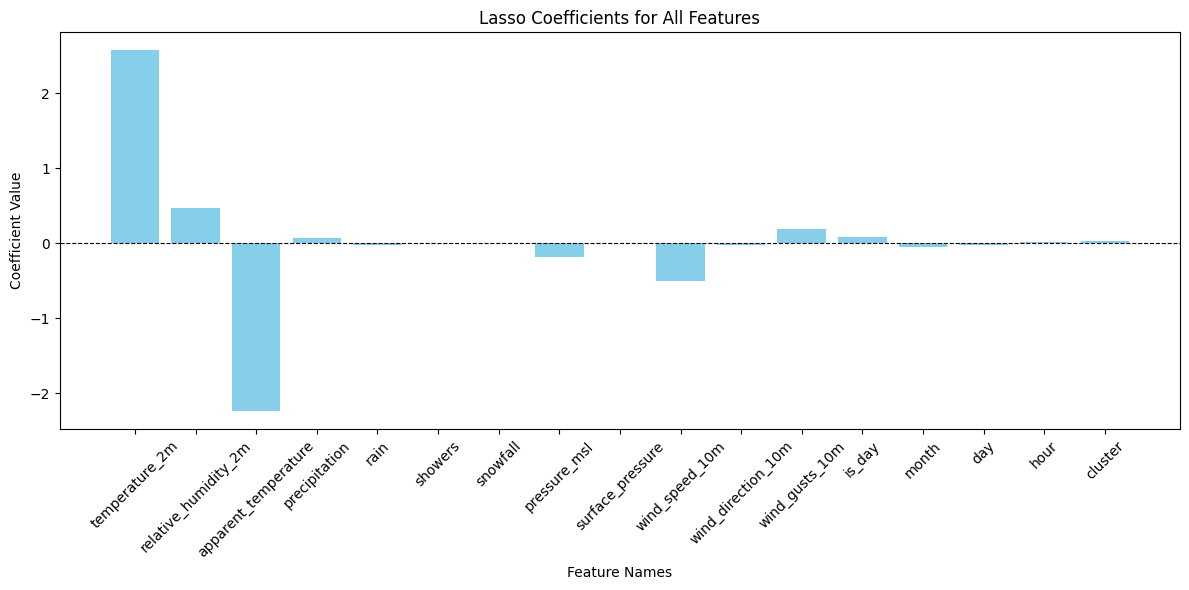

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso_coefficients, color='skyblue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Lasso Coefficients for All Features")
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

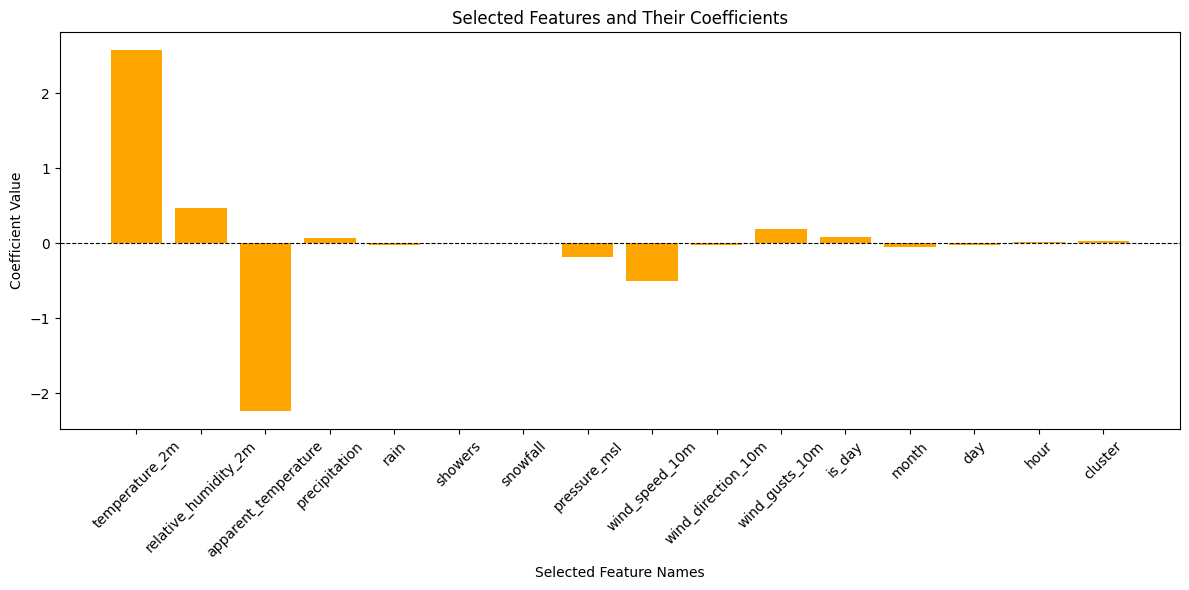

In [25]:
plt.figure(figsize=(12, 6))
plt.bar(selected_feature_names, selected_coefficients, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Selected Features and Their Coefficients")
plt.xlabel("Selected Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
selected_coefficients

array([ 2.57377   ,  0.47471889, -2.23923338,  0.07085073, -0.0219487 ,
        0.00828735,  0.005459  , -0.18440248, -0.50355091, -0.01656195,
        0.19368734,  0.09124226, -0.05220387, -0.01694287,  0.01792808,
        0.02591221])

In [27]:
selected_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16])

In [28]:
x_train = x_train[:, selected_features_indices]
x_test = x_test[:, selected_features_indices]

### Machine learning

In [29]:
def mad_error(y_true, y_pred):
    # Ensure inputs are numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate absolute deviations
    absolute_deviation = np.abs(y_true - y_pred)
    
    # Compute the mean of absolute deviations
    mad_error = np.mean(absolute_deviation)
    
    return mad_error

In [30]:
df1 = df[['cloud_cover', 'temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'precipitation', 'rain',
          'showers', 'snowfall', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'wind_gusts_10m', 'is_day',
          'month', 'day', 'hour', 'cluster']]

In [31]:
lagged_data = df1.copy()
for lag in range(1, 2):  # Create lags
    for col in df1.columns:
        lagged_data[f'{col}_lag_{lag}'] = df1[col].shift(lag)

In [32]:
for lag in range(1, 6):
    lagged_data[f'future_cloud_{lag}'] = lagged_data['cloud_cover'].shift(-lag)

In [33]:
lagged_data = lagged_data.dropna()
lagged_data.reset_index(drop=True, inplace = True)

In [34]:
lagged_data.head(2)

,cloud_cover,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster,cloud_cover_lag_1,temperature_2m_lag_1,relative_humidity_2m_lag_1,apparent_temperature_lag_1,precipitation_lag_1,rain_lag_1,showers_lag_1,snowfall_lag_1,pressure_msl_lag_1,wind_speed_10m_lag_1,wind_direction_10m_lag_1,wind_gusts_10m_lag_1,is_day_lag_1,month_lag_1,day_lag_1,hour_lag_1,cluster_lag_1,future_cloud_1,future_cloud_2,future_cloud_3,future_cloud_4,future_cloud_5
0,19.0,10.521500,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,14.707222,201.54105,43.56,0.0,1,1,1,4,7.0,11.0215,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,16.981165,212.00534,51.12,0.0,1.0,1.0,0.0,4.0,100.0,100.0,100.0,100.0,100.0
1,100.0,10.721499,96.0,8.677092,0.0,0.0,0.0,0.0,1019.8,14.345898,197.52567,39.96,0.0,1,1,2,4,19.0,10.5215,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,14.707222,201.54105,43.56,0.0,1.0,1.0,1.0,4.0,100.0,100.0,100.0,100.0,100.0


In [35]:
split_len = round(len(lagged_data.index) * 0.8)
split_len

19867

In [36]:
train = lagged_data.iloc[:split_len]
test = lagged_data.iloc[split_len:]
test.reset_index(drop = True, inplace = True)

In [37]:
x_train = train.drop(['future_cloud_1', 'future_cloud_2', 'future_cloud_3', 'future_cloud_4', 'future_cloud_5'], axis = 1)
y_train = train[['future_cloud_1', 'future_cloud_2', 'future_cloud_3', 'future_cloud_4', 'future_cloud_5']]
x_test = test.drop(['future_cloud_1', 'future_cloud_2', 'future_cloud_3', 'future_cloud_4', 'future_cloud_5'], axis = 1)
y_test = test[['future_cloud_1', 'future_cloud_2', 'future_cloud_3', 'future_cloud_4', 'future_cloud_5']]

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19867, 34)
(19867, 5)
(4967, 34)
(4967, 5)


In [39]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [40]:
y_test_rescaled = y_scaler.inverse_transform(y_test)

In [41]:
import joblib
joblib.dump(x_scaler, 'x_scaler_cloud.joblib')
joblib.dump(y_scaler, 'y_scaler_cloud.joblib')

['y_scaler_cloud.joblib']

#### Linear Regression

In [42]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

LR = MultiOutputRegressor(LinearRegression())
LR.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [92]:
pred = LR.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [93]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [94]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[15.951725090976156, 19.60205841816487, 21.870870835721536, 23.642076412374912, 25.005638204414403]
Average error:  21.214473792330374


#### KNN

In [95]:
from sklearn.neighbors import KNeighborsRegressor

KNN = MultiOutputRegressor(KNeighborsRegressor())
KNN.fit(x_train, y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [96]:
pred = KNN.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [97]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [98]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[18.75023152808536, 21.892369639621503, 24.084759412119993, 25.789128246426415, 26.76798872558889]
Average error:  23.456895510368433


#### DT

In [99]:
from sklearn.tree import DecisionTreeRegressor

DT = MultiOutputRegressor(DecisionTreeRegressor())
DT.fit(x_train, y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor())

In [100]:
pred = DT.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [101]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [102]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[22.103080330179182, 25.917455204348702, 28.125226494866116, 30.118582645460037, 31.493658143748743]
Average error:  27.55160056372055


#### Random Forest

In [103]:
from sklearn.ensemble import RandomForestRegressor

RF = MultiOutputRegressor(RandomForestRegressor())
RF.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

<Axes: title={'center': 'Feature Importances (Mean Across Targets)'}>

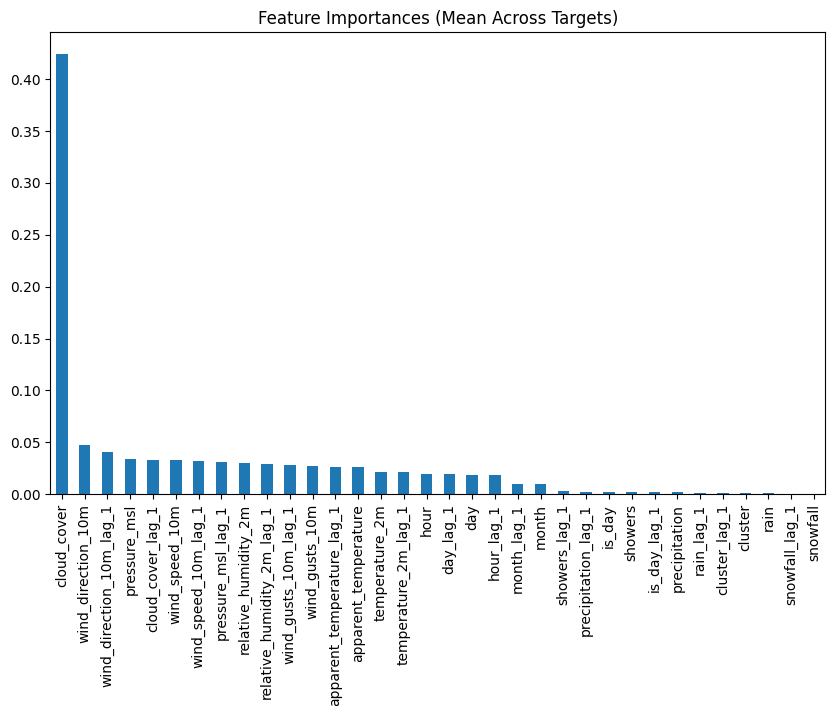

In [104]:
# Extract feature importances for each target
temp = train.drop(['future_cloud_1', 'future_cloud_2', 'future_cloud_3', 'future_cloud_4', 'future_cloud_5'], axis = 1)
temp2 = train[['future_cloud_1', 'future_cloud_2', 'future_cloud_3', 'future_cloud_4', 'future_cloud_5']]
feature_names = list(temp.columns)
target_names = list(temp2.columns)
importances = pd.DataFrame(index=feature_names)

for i, estimator in enumerate(RF.estimators_):
    importances[target_names[i]] = estimator.feature_importances_

# Calculate average importance across all targets
importances['Mean Importance'] = importances.mean(axis=1)

# Visualize the feature importances
importances['Mean Importance'].sort_values(ascending=False).plot(kind='bar', figsize=(10, 6),
                                                                 title='Feature Importances (Mean Across Targets)')

In [105]:
pred = RF.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [106]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [107]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[17.095208375276837, 20.47677269981881, 22.715339238977254, 24.394336621703243, 25.542345480169114]
Average error:  22.044800483189054


#### Gradient Boosting

In [108]:
from sklearn.ensemble import GradientBoostingRegressor

GB = MultiOutputRegressor(GradientBoostingRegressor())
GB.fit(x_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [109]:
pred = GB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [110]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [111]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[16.191510089977797, 19.892615258393015, 22.188451187446518, 23.818862395528157, 25.03007365311641]
Average error:  21.42430251689238


#### Hist Gradient Boosting

In [43]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB = MultiOutputRegressor(HistGradientBoostingRegressor())
HGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [44]:
pred = HGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [45]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [46]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[np.float64(16.10277942757394), np.float64(20.046025004371064), np.float64(22.042226528883514), np.float64(23.71210346968178), np.float64(24.985652200450676)]
Average error:  21.377757326192192


#### XGBoost

In [116]:
from xgboost import XGBRegressor

XGB = MultiOutputRegressor(XGBRegressor())
XGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [117]:
pred = XGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [118]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [119]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[17.699846000427303, 20.969235818931363, 22.893392753695274, 24.729498633759732, 25.721111774378578]
Average error:  22.402616996238454


#### LGBM

In [120]:
from lightgbm import LGBMRegressor

LGBM = MultiOutputRegressor(LGBMRegressor())
LGBM.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor())

In [121]:
pred = LGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [122]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [123]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[16.142045477445567, 19.769861873530445, 22.07016110483436, 23.6460339743571, 24.96730916334377]
Average error:  21.319082318702247


#### CatBoost

In [124]:
from catboost import CatBoostRegressor

CGBM = MultiOutputRegressor(CatBoostRegressor())
CGBM.fit(x_train, y_train)

Learning rate set to 0.065658
0:	learn: 0.9595373	total: 4.85ms	remaining: 4.84s
1:	learn: 0.9223627	total: 9.13ms	remaining: 4.56s
2:	learn: 0.8890317	total: 13.4ms	remaining: 4.44s
3:	learn: 0.8585725	total: 17.4ms	remaining: 4.34s
4:	learn: 0.8308240	total: 21.3ms	remaining: 4.24s
5:	learn: 0.8056673	total: 25.2ms	remaining: 4.17s
6:	learn: 0.7832880	total: 29ms	remaining: 4.11s
7:	learn: 0.7634412	total: 32.8ms	remaining: 4.07s
8:	learn: 0.7447820	total: 37.8ms	remaining: 4.16s
9:	learn: 0.7279015	total: 41.6ms	remaining: 4.12s
10:	learn: 0.7133600	total: 45.4ms	remaining: 4.08s
11:	learn: 0.7000154	total: 49.7ms	remaining: 4.09s
12:	learn: 0.6880210	total: 53.8ms	remaining: 4.08s
13:	learn: 0.6770672	total: 57.8ms	remaining: 4.07s
14:	learn: 0.6673777	total: 61.4ms	remaining: 4.03s
15:	learn: 0.6587821	total: 65.3ms	remaining: 4.02s
16:	learn: 0.6508641	total: 68.9ms	remaining: 3.98s
17:	learn: 0.6441826	total: 72.2ms	remaining: 3.94s
18:	learn: 0.6378656	total: 75.9ms	remaining: 

207:	learn: 0.5604820	total: 810ms	remaining: 3.08s
208:	learn: 0.5604575	total: 814ms	remaining: 3.08s
209:	learn: 0.5602691	total: 818ms	remaining: 3.08s
210:	learn: 0.5601084	total: 822ms	remaining: 3.07s
211:	learn: 0.5599776	total: 827ms	remaining: 3.07s
212:	learn: 0.5599049	total: 831ms	remaining: 3.07s
213:	learn: 0.5597812	total: 835ms	remaining: 3.06s
214:	learn: 0.5597425	total: 838ms	remaining: 3.06s
215:	learn: 0.5595387	total: 842ms	remaining: 3.06s
216:	learn: 0.5593664	total: 845ms	remaining: 3.05s
217:	learn: 0.5592155	total: 849ms	remaining: 3.05s
218:	learn: 0.5591034	total: 853ms	remaining: 3.04s
219:	learn: 0.5589770	total: 856ms	remaining: 3.04s
220:	learn: 0.5589694	total: 860ms	remaining: 3.03s
221:	learn: 0.5587911	total: 864ms	remaining: 3.03s
222:	learn: 0.5587220	total: 868ms	remaining: 3.02s
223:	learn: 0.5587139	total: 871ms	remaining: 3.02s
224:	learn: 0.5585610	total: 875ms	remaining: 3.01s
225:	learn: 0.5585540	total: 879ms	remaining: 3.01s
226:	learn: 

371:	learn: 0.5401628	total: 1.43s	remaining: 2.41s
372:	learn: 0.5400040	total: 1.43s	remaining: 2.41s
373:	learn: 0.5398161	total: 1.44s	remaining: 2.4s
374:	learn: 0.5396793	total: 1.45s	remaining: 2.41s
375:	learn: 0.5395724	total: 1.45s	remaining: 2.41s
376:	learn: 0.5394102	total: 1.46s	remaining: 2.41s
377:	learn: 0.5393336	total: 1.46s	remaining: 2.4s
378:	learn: 0.5392789	total: 1.47s	remaining: 2.4s
379:	learn: 0.5391502	total: 1.47s	remaining: 2.4s
380:	learn: 0.5391350	total: 1.47s	remaining: 2.4s
381:	learn: 0.5390527	total: 1.48s	remaining: 2.39s
382:	learn: 0.5388722	total: 1.48s	remaining: 2.39s
383:	learn: 0.5387447	total: 1.49s	remaining: 2.39s
384:	learn: 0.5386576	total: 1.49s	remaining: 2.38s
385:	learn: 0.5386085	total: 1.5s	remaining: 2.38s
386:	learn: 0.5385189	total: 1.5s	remaining: 2.38s
387:	learn: 0.5384935	total: 1.5s	remaining: 2.37s
388:	learn: 0.5384034	total: 1.51s	remaining: 2.37s
389:	learn: 0.5382425	total: 1.51s	remaining: 2.37s
390:	learn: 0.538110

574:	learn: 0.5194492	total: 2.27s	remaining: 1.68s
575:	learn: 0.5194338	total: 2.27s	remaining: 1.67s
576:	learn: 0.5193026	total: 2.28s	remaining: 1.67s
577:	learn: 0.5191777	total: 2.28s	remaining: 1.67s
578:	learn: 0.5189794	total: 2.29s	remaining: 1.66s
579:	learn: 0.5188785	total: 2.29s	remaining: 1.66s
580:	learn: 0.5187213	total: 2.29s	remaining: 1.66s
581:	learn: 0.5186337	total: 2.3s	remaining: 1.65s
582:	learn: 0.5185129	total: 2.3s	remaining: 1.65s
583:	learn: 0.5184326	total: 2.31s	remaining: 1.64s
584:	learn: 0.5182426	total: 2.31s	remaining: 1.64s
585:	learn: 0.5182199	total: 2.31s	remaining: 1.64s
586:	learn: 0.5181305	total: 2.32s	remaining: 1.63s
587:	learn: 0.5180491	total: 2.32s	remaining: 1.63s
588:	learn: 0.5178962	total: 2.33s	remaining: 1.62s
589:	learn: 0.5177551	total: 2.33s	remaining: 1.62s
590:	learn: 0.5176474	total: 2.35s	remaining: 1.63s
591:	learn: 0.5175247	total: 2.35s	remaining: 1.62s
592:	learn: 0.5174115	total: 2.36s	remaining: 1.62s
593:	learn: 0.

783:	learn: 0.4993597	total: 3.09s	remaining: 851ms
784:	learn: 0.4992702	total: 3.09s	remaining: 847ms
785:	learn: 0.4991921	total: 3.1s	remaining: 843ms
786:	learn: 0.4991340	total: 3.1s	remaining: 839ms
787:	learn: 0.4990654	total: 3.1s	remaining: 835ms
788:	learn: 0.4989964	total: 3.11s	remaining: 831ms
789:	learn: 0.4989061	total: 3.11s	remaining: 827ms
790:	learn: 0.4988529	total: 3.11s	remaining: 823ms
791:	learn: 0.4987390	total: 3.12s	remaining: 819ms
792:	learn: 0.4986036	total: 3.12s	remaining: 815ms
793:	learn: 0.4985398	total: 3.13s	remaining: 811ms
794:	learn: 0.4984838	total: 3.13s	remaining: 807ms
795:	learn: 0.4984646	total: 3.13s	remaining: 803ms
796:	learn: 0.4984625	total: 3.14s	remaining: 799ms
797:	learn: 0.4983471	total: 3.14s	remaining: 795ms
798:	learn: 0.4982615	total: 3.15s	remaining: 791ms
799:	learn: 0.4981177	total: 3.15s	remaining: 787ms
800:	learn: 0.4980048	total: 3.15s	remaining: 783ms
801:	learn: 0.4980003	total: 3.16s	remaining: 779ms
802:	learn: 0.4

941:	learn: 0.4877173	total: 3.69s	remaining: 227ms
942:	learn: 0.4876764	total: 3.7s	remaining: 223ms
943:	learn: 0.4876729	total: 3.7s	remaining: 220ms
944:	learn: 0.4875825	total: 3.7s	remaining: 216ms
945:	learn: 0.4875366	total: 3.71s	remaining: 212ms
946:	learn: 0.4875127	total: 3.71s	remaining: 208ms
947:	learn: 0.4873453	total: 3.71s	remaining: 204ms
948:	learn: 0.4872515	total: 3.72s	remaining: 200ms
949:	learn: 0.4871253	total: 3.72s	remaining: 196ms
950:	learn: 0.4870386	total: 3.73s	remaining: 192ms
951:	learn: 0.4869451	total: 3.73s	remaining: 188ms
952:	learn: 0.4868757	total: 3.73s	remaining: 184ms
953:	learn: 0.4867302	total: 3.74s	remaining: 180ms
954:	learn: 0.4867046	total: 3.74s	remaining: 176ms
955:	learn: 0.4866200	total: 3.75s	remaining: 172ms
956:	learn: 0.4865654	total: 3.75s	remaining: 168ms
957:	learn: 0.4864788	total: 3.75s	remaining: 165ms
958:	learn: 0.4863758	total: 3.76s	remaining: 161ms
959:	learn: 0.4863524	total: 3.76s	remaining: 157ms
960:	learn: 0.4

155:	learn: 0.6704026	total: 595ms	remaining: 3.22s
156:	learn: 0.6701782	total: 598ms	remaining: 3.21s
157:	learn: 0.6699825	total: 603ms	remaining: 3.21s
158:	learn: 0.6698288	total: 607ms	remaining: 3.21s
159:	learn: 0.6696341	total: 611ms	remaining: 3.21s
160:	learn: 0.6694289	total: 614ms	remaining: 3.2s
161:	learn: 0.6691918	total: 618ms	remaining: 3.2s
162:	learn: 0.6689407	total: 622ms	remaining: 3.19s
163:	learn: 0.6686199	total: 625ms	remaining: 3.19s
164:	learn: 0.6684066	total: 629ms	remaining: 3.18s
165:	learn: 0.6682152	total: 633ms	remaining: 3.18s
166:	learn: 0.6680478	total: 637ms	remaining: 3.18s
167:	learn: 0.6677974	total: 641ms	remaining: 3.17s
168:	learn: 0.6676066	total: 645ms	remaining: 3.17s
169:	learn: 0.6673174	total: 649ms	remaining: 3.17s
170:	learn: 0.6669837	total: 653ms	remaining: 3.17s
171:	learn: 0.6668268	total: 658ms	remaining: 3.17s
172:	learn: 0.6667651	total: 661ms	remaining: 3.16s
173:	learn: 0.6666597	total: 666ms	remaining: 3.16s
174:	learn: 0.

314:	learn: 0.6424486	total: 1.23s	remaining: 2.67s
315:	learn: 0.6424074	total: 1.23s	remaining: 2.67s
316:	learn: 0.6423510	total: 1.24s	remaining: 2.66s
317:	learn: 0.6421971	total: 1.24s	remaining: 2.66s
318:	learn: 0.6420151	total: 1.25s	remaining: 2.67s
319:	learn: 0.6417913	total: 1.25s	remaining: 2.67s
320:	learn: 0.6415890	total: 1.26s	remaining: 2.66s
321:	learn: 0.6414616	total: 1.26s	remaining: 2.66s
322:	learn: 0.6412708	total: 1.27s	remaining: 2.65s
323:	learn: 0.6411006	total: 1.27s	remaining: 2.65s
324:	learn: 0.6409282	total: 1.27s	remaining: 2.65s
325:	learn: 0.6407379	total: 1.28s	remaining: 2.64s
326:	learn: 0.6406774	total: 1.28s	remaining: 2.64s
327:	learn: 0.6405288	total: 1.28s	remaining: 2.63s
328:	learn: 0.6403779	total: 1.29s	remaining: 2.63s
329:	learn: 0.6401522	total: 1.29s	remaining: 2.63s
330:	learn: 0.6401045	total: 1.3s	remaining: 2.62s
331:	learn: 0.6398235	total: 1.3s	remaining: 2.62s
332:	learn: 0.6397127	total: 1.3s	remaining: 2.61s
333:	learn: 0.6

478:	learn: 0.6177801	total: 1.87s	remaining: 2.03s
479:	learn: 0.6176065	total: 1.87s	remaining: 2.03s
480:	learn: 0.6174880	total: 1.87s	remaining: 2.02s
481:	learn: 0.6172964	total: 1.88s	remaining: 2.02s
482:	learn: 0.6172145	total: 1.88s	remaining: 2.02s
483:	learn: 0.6171100	total: 1.89s	remaining: 2.01s
484:	learn: 0.6169353	total: 1.89s	remaining: 2.01s
485:	learn: 0.6167736	total: 1.9s	remaining: 2.01s
486:	learn: 0.6167608	total: 1.9s	remaining: 2s
487:	learn: 0.6166108	total: 1.9s	remaining: 2s
488:	learn: 0.6164709	total: 1.91s	remaining: 1.99s
489:	learn: 0.6163845	total: 1.91s	remaining: 1.99s
490:	learn: 0.6162614	total: 1.92s	remaining: 1.99s
491:	learn: 0.6161358	total: 1.92s	remaining: 1.98s
492:	learn: 0.6160500	total: 1.92s	remaining: 1.98s
493:	learn: 0.6158905	total: 1.93s	remaining: 1.97s
494:	learn: 0.6158500	total: 1.93s	remaining: 1.97s
495:	learn: 0.6156213	total: 1.93s	remaining: 1.97s
496:	learn: 0.6154528	total: 1.94s	remaining: 1.96s
497:	learn: 0.6153360

637:	learn: 0.5966779	total: 2.5s	remaining: 1.42s
638:	learn: 0.5965402	total: 2.5s	remaining: 1.42s
639:	learn: 0.5963954	total: 2.51s	remaining: 1.41s
640:	learn: 0.5962087	total: 2.51s	remaining: 1.41s
641:	learn: 0.5960744	total: 2.52s	remaining: 1.4s
642:	learn: 0.5959250	total: 2.52s	remaining: 1.4s
643:	learn: 0.5959235	total: 2.52s	remaining: 1.4s
644:	learn: 0.5958684	total: 2.53s	remaining: 1.39s
645:	learn: 0.5956919	total: 2.53s	remaining: 1.39s
646:	learn: 0.5955231	total: 2.54s	remaining: 1.38s
647:	learn: 0.5953905	total: 2.54s	remaining: 1.38s
648:	learn: 0.5952553	total: 2.54s	remaining: 1.38s
649:	learn: 0.5951504	total: 2.55s	remaining: 1.37s
650:	learn: 0.5951487	total: 2.55s	remaining: 1.37s
651:	learn: 0.5949961	total: 2.55s	remaining: 1.36s
652:	learn: 0.5948943	total: 2.56s	remaining: 1.36s
653:	learn: 0.5948198	total: 2.56s	remaining: 1.35s
654:	learn: 0.5946436	total: 2.56s	remaining: 1.35s
655:	learn: 0.5944134	total: 2.57s	remaining: 1.35s
656:	learn: 0.594

804:	learn: 0.5744464	total: 3.14s	remaining: 761ms
805:	learn: 0.5744047	total: 3.14s	remaining: 757ms
806:	learn: 0.5743180	total: 3.15s	remaining: 753ms
807:	learn: 0.5741830	total: 3.15s	remaining: 749ms
808:	learn: 0.5740386	total: 3.16s	remaining: 745ms
809:	learn: 0.5739438	total: 3.16s	remaining: 741ms
810:	learn: 0.5738169	total: 3.17s	remaining: 738ms
811:	learn: 0.5738153	total: 3.17s	remaining: 734ms
812:	learn: 0.5737532	total: 3.17s	remaining: 730ms
813:	learn: 0.5735722	total: 3.18s	remaining: 726ms
814:	learn: 0.5734603	total: 3.18s	remaining: 722ms
815:	learn: 0.5733533	total: 3.18s	remaining: 718ms
816:	learn: 0.5733520	total: 3.19s	remaining: 714ms
817:	learn: 0.5732237	total: 3.19s	remaining: 710ms
818:	learn: 0.5731121	total: 3.19s	remaining: 706ms
819:	learn: 0.5729352	total: 3.2s	remaining: 703ms
820:	learn: 0.5729181	total: 3.2s	remaining: 699ms
821:	learn: 0.5728670	total: 3.21s	remaining: 695ms
822:	learn: 0.5727255	total: 3.21s	remaining: 691ms
823:	learn: 0.

965:	learn: 0.5564880	total: 3.77s	remaining: 133ms
966:	learn: 0.5563492	total: 3.78s	remaining: 129ms
967:	learn: 0.5562625	total: 3.78s	remaining: 125ms
968:	learn: 0.5561408	total: 3.79s	remaining: 121ms
969:	learn: 0.5560102	total: 3.79s	remaining: 117ms
970:	learn: 0.5559169	total: 3.8s	remaining: 113ms
971:	learn: 0.5559102	total: 3.8s	remaining: 109ms
972:	learn: 0.5558212	total: 3.81s	remaining: 106ms
973:	learn: 0.5557165	total: 3.81s	remaining: 102ms
974:	learn: 0.5556093	total: 3.81s	remaining: 97.8ms
975:	learn: 0.5555494	total: 3.82s	remaining: 93.9ms
976:	learn: 0.5555132	total: 3.82s	remaining: 90ms
977:	learn: 0.5554298	total: 3.83s	remaining: 86.1ms
978:	learn: 0.5554277	total: 3.83s	remaining: 82.2ms
979:	learn: 0.5553690	total: 3.83s	remaining: 78.3ms
980:	learn: 0.5552679	total: 3.84s	remaining: 74.4ms
981:	learn: 0.5551416	total: 3.84s	remaining: 70.4ms
982:	learn: 0.5549906	total: 3.85s	remaining: 66.5ms
983:	learn: 0.5549713	total: 3.85s	remaining: 62.6ms
984:	l

154:	learn: 0.7212660	total: 630ms	remaining: 3.43s
155:	learn: 0.7210317	total: 633ms	remaining: 3.43s
156:	learn: 0.7207972	total: 637ms	remaining: 3.42s
157:	learn: 0.7205979	total: 642ms	remaining: 3.42s
158:	learn: 0.7205166	total: 646ms	remaining: 3.42s
159:	learn: 0.7203470	total: 650ms	remaining: 3.41s
160:	learn: 0.7200954	total: 654ms	remaining: 3.41s
161:	learn: 0.7198134	total: 658ms	remaining: 3.4s
162:	learn: 0.7195027	total: 663ms	remaining: 3.4s
163:	learn: 0.7192713	total: 667ms	remaining: 3.4s
164:	learn: 0.7191182	total: 671ms	remaining: 3.4s
165:	learn: 0.7188063	total: 676ms	remaining: 3.39s
166:	learn: 0.7185034	total: 680ms	remaining: 3.39s
167:	learn: 0.7182000	total: 683ms	remaining: 3.38s
168:	learn: 0.7180436	total: 688ms	remaining: 3.38s
169:	learn: 0.7178260	total: 692ms	remaining: 3.38s
170:	learn: 0.7177098	total: 696ms	remaining: 3.37s
171:	learn: 0.7174440	total: 700ms	remaining: 3.37s
172:	learn: 0.7171406	total: 704ms	remaining: 3.36s
173:	learn: 0.71

316:	learn: 0.6864172	total: 1.26s	remaining: 2.71s
317:	learn: 0.6862622	total: 1.26s	remaining: 2.71s
318:	learn: 0.6861077	total: 1.27s	remaining: 2.71s
319:	learn: 0.6859049	total: 1.27s	remaining: 2.7s
320:	learn: 0.6858964	total: 1.27s	remaining: 2.7s
321:	learn: 0.6856649	total: 1.28s	remaining: 2.69s
322:	learn: 0.6853636	total: 1.28s	remaining: 2.69s
323:	learn: 0.6851814	total: 1.29s	remaining: 2.68s
324:	learn: 0.6849883	total: 1.29s	remaining: 2.68s
325:	learn: 0.6849311	total: 1.29s	remaining: 2.67s
326:	learn: 0.6847000	total: 1.3s	remaining: 2.67s
327:	learn: 0.6844196	total: 1.3s	remaining: 2.67s
328:	learn: 0.6840908	total: 1.31s	remaining: 2.66s
329:	learn: 0.6839694	total: 1.31s	remaining: 2.66s
330:	learn: 0.6836941	total: 1.31s	remaining: 2.66s
331:	learn: 0.6834849	total: 1.32s	remaining: 2.65s
332:	learn: 0.6834416	total: 1.32s	remaining: 2.65s
333:	learn: 0.6832462	total: 1.32s	remaining: 2.64s
334:	learn: 0.6830624	total: 1.33s	remaining: 2.64s
335:	learn: 0.68

475:	learn: 0.6577434	total: 1.88s	remaining: 2.07s
476:	learn: 0.6576083	total: 1.89s	remaining: 2.07s
477:	learn: 0.6574856	total: 1.89s	remaining: 2.06s
478:	learn: 0.6574258	total: 1.9s	remaining: 2.06s
479:	learn: 0.6570536	total: 1.9s	remaining: 2.06s
480:	learn: 0.6568852	total: 1.9s	remaining: 2.05s
481:	learn: 0.6566613	total: 1.91s	remaining: 2.05s
482:	learn: 0.6564665	total: 1.91s	remaining: 2.05s
483:	learn: 0.6562635	total: 1.92s	remaining: 2.04s
484:	learn: 0.6560758	total: 1.92s	remaining: 2.04s
485:	learn: 0.6558443	total: 1.93s	remaining: 2.04s
486:	learn: 0.6556028	total: 1.93s	remaining: 2.03s
487:	learn: 0.6554122	total: 1.93s	remaining: 2.03s
488:	learn: 0.6552681	total: 1.94s	remaining: 2.02s
489:	learn: 0.6552607	total: 1.94s	remaining: 2.02s
490:	learn: 0.6550912	total: 1.95s	remaining: 2.02s
491:	learn: 0.6549011	total: 1.95s	remaining: 2.01s
492:	learn: 0.6546852	total: 1.95s	remaining: 2.01s
493:	learn: 0.6544740	total: 1.96s	remaining: 2s
494:	learn: 0.6542

684:	learn: 0.6242330	total: 2.71s	remaining: 1.24s
685:	learn: 0.6240446	total: 2.71s	remaining: 1.24s
686:	learn: 0.6239866	total: 2.71s	remaining: 1.24s
687:	learn: 0.6239053	total: 2.72s	remaining: 1.23s
688:	learn: 0.6237904	total: 2.72s	remaining: 1.23s
689:	learn: 0.6236313	total: 2.73s	remaining: 1.23s
690:	learn: 0.6234712	total: 2.73s	remaining: 1.22s
691:	learn: 0.6233113	total: 2.73s	remaining: 1.22s
692:	learn: 0.6231999	total: 2.74s	remaining: 1.21s
693:	learn: 0.6230084	total: 2.74s	remaining: 1.21s
694:	learn: 0.6229167	total: 2.75s	remaining: 1.21s
695:	learn: 0.6229137	total: 2.75s	remaining: 1.2s
696:	learn: 0.6228162	total: 2.75s	remaining: 1.2s
697:	learn: 0.6228134	total: 2.76s	remaining: 1.19s
698:	learn: 0.6225980	total: 2.76s	remaining: 1.19s
699:	learn: 0.6224259	total: 2.76s	remaining: 1.18s
700:	learn: 0.6223479	total: 2.77s	remaining: 1.18s
701:	learn: 0.6222202	total: 2.77s	remaining: 1.18s
702:	learn: 0.6220100	total: 2.77s	remaining: 1.17s
703:	learn: 0.

895:	learn: 0.5959650	total: 3.52s	remaining: 408ms
896:	learn: 0.5957656	total: 3.52s	remaining: 405ms
897:	learn: 0.5955988	total: 3.53s	remaining: 401ms
898:	learn: 0.5954683	total: 3.53s	remaining: 397ms
899:	learn: 0.5953751	total: 3.54s	remaining: 393ms
900:	learn: 0.5951936	total: 3.54s	remaining: 389ms
901:	learn: 0.5951334	total: 3.54s	remaining: 385ms
902:	learn: 0.5949773	total: 3.55s	remaining: 381ms
903:	learn: 0.5948457	total: 3.55s	remaining: 377ms
904:	learn: 0.5947244	total: 3.55s	remaining: 373ms
905:	learn: 0.5946045	total: 3.56s	remaining: 369ms
906:	learn: 0.5943918	total: 3.56s	remaining: 365ms
907:	learn: 0.5942875	total: 3.56s	remaining: 361ms
908:	learn: 0.5941760	total: 3.57s	remaining: 357ms
909:	learn: 0.5940082	total: 3.57s	remaining: 353ms
910:	learn: 0.5938871	total: 3.58s	remaining: 349ms
911:	learn: 0.5938190	total: 3.58s	remaining: 345ms
912:	learn: 0.5936834	total: 3.58s	remaining: 341ms
913:	learn: 0.5935861	total: 3.59s	remaining: 338ms
914:	learn: 

95:	learn: 0.7720160	total: 412ms	remaining: 3.88s
96:	learn: 0.7717627	total: 417ms	remaining: 3.88s
97:	learn: 0.7713066	total: 421ms	remaining: 3.87s
98:	learn: 0.7709868	total: 425ms	remaining: 3.87s
99:	learn: 0.7705779	total: 430ms	remaining: 3.87s
100:	learn: 0.7703374	total: 435ms	remaining: 3.87s
101:	learn: 0.7699928	total: 439ms	remaining: 3.87s
102:	learn: 0.7695842	total: 443ms	remaining: 3.86s
103:	learn: 0.7693536	total: 447ms	remaining: 3.85s
104:	learn: 0.7690528	total: 452ms	remaining: 3.85s
105:	learn: 0.7687962	total: 455ms	remaining: 3.84s
106:	learn: 0.7686669	total: 459ms	remaining: 3.83s
107:	learn: 0.7681645	total: 463ms	remaining: 3.82s
108:	learn: 0.7678785	total: 466ms	remaining: 3.81s
109:	learn: 0.7676055	total: 471ms	remaining: 3.81s
110:	learn: 0.7673341	total: 475ms	remaining: 3.8s
111:	learn: 0.7669962	total: 479ms	remaining: 3.8s
112:	learn: 0.7667398	total: 483ms	remaining: 3.79s
113:	learn: 0.7663802	total: 487ms	remaining: 3.79s
114:	learn: 0.76611

258:	learn: 0.7235317	total: 1.04s	remaining: 2.99s
259:	learn: 0.7231863	total: 1.05s	remaining: 2.99s
260:	learn: 0.7229083	total: 1.05s	remaining: 2.98s
261:	learn: 0.7225340	total: 1.06s	remaining: 2.98s
262:	learn: 0.7223200	total: 1.06s	remaining: 2.98s
263:	learn: 0.7220488	total: 1.07s	remaining: 2.97s
264:	learn: 0.7218361	total: 1.07s	remaining: 2.97s
265:	learn: 0.7215772	total: 1.07s	remaining: 2.96s
266:	learn: 0.7215668	total: 1.08s	remaining: 2.96s
267:	learn: 0.7212525	total: 1.08s	remaining: 2.96s
268:	learn: 0.7209769	total: 1.09s	remaining: 2.95s
269:	learn: 0.7206817	total: 1.09s	remaining: 2.95s
270:	learn: 0.7203408	total: 1.09s	remaining: 2.95s
271:	learn: 0.7200448	total: 1.1s	remaining: 2.94s
272:	learn: 0.7198161	total: 1.1s	remaining: 2.94s
273:	learn: 0.7195623	total: 1.11s	remaining: 2.93s
274:	learn: 0.7191464	total: 1.11s	remaining: 2.93s
275:	learn: 0.7188918	total: 1.11s	remaining: 2.92s
276:	learn: 0.7187248	total: 1.12s	remaining: 2.92s
277:	learn: 0.

463:	learn: 0.6788829	total: 1.86s	remaining: 2.15s
464:	learn: 0.6786178	total: 1.86s	remaining: 2.15s
465:	learn: 0.6785101	total: 1.87s	remaining: 2.14s
466:	learn: 0.6783992	total: 1.87s	remaining: 2.14s
467:	learn: 0.6783902	total: 1.88s	remaining: 2.14s
468:	learn: 0.6782790	total: 1.88s	remaining: 2.13s
469:	learn: 0.6780707	total: 1.89s	remaining: 2.13s
470:	learn: 0.6777591	total: 1.89s	remaining: 2.12s
471:	learn: 0.6776276	total: 1.89s	remaining: 2.12s
472:	learn: 0.6774793	total: 1.9s	remaining: 2.11s
473:	learn: 0.6773263	total: 1.9s	remaining: 2.11s
474:	learn: 0.6771252	total: 1.91s	remaining: 2.11s
475:	learn: 0.6769542	total: 1.91s	remaining: 2.1s
476:	learn: 0.6767353	total: 1.91s	remaining: 2.1s
477:	learn: 0.6765303	total: 1.92s	remaining: 2.09s
478:	learn: 0.6763256	total: 1.92s	remaining: 2.09s
479:	learn: 0.6760323	total: 1.93s	remaining: 2.08s
480:	learn: 0.6758747	total: 1.93s	remaining: 2.08s
481:	learn: 0.6755211	total: 1.93s	remaining: 2.08s
482:	learn: 0.67

669:	learn: 0.6453574	total: 2.68s	remaining: 1.32s
670:	learn: 0.6452921	total: 2.68s	remaining: 1.31s
671:	learn: 0.6452828	total: 2.69s	remaining: 1.31s
672:	learn: 0.6451258	total: 2.69s	remaining: 1.31s
673:	learn: 0.6449776	total: 2.69s	remaining: 1.3s
674:	learn: 0.6448124	total: 2.7s	remaining: 1.3s
675:	learn: 0.6446853	total: 2.7s	remaining: 1.29s
676:	learn: 0.6446412	total: 2.71s	remaining: 1.29s
677:	learn: 0.6445331	total: 2.71s	remaining: 1.29s
678:	learn: 0.6444718	total: 2.71s	remaining: 1.28s
679:	learn: 0.6443208	total: 2.72s	remaining: 1.28s
680:	learn: 0.6441067	total: 2.72s	remaining: 1.27s
681:	learn: 0.6439680	total: 2.73s	remaining: 1.27s
682:	learn: 0.6437583	total: 2.73s	remaining: 1.27s
683:	learn: 0.6437057	total: 2.73s	remaining: 1.26s
684:	learn: 0.6435692	total: 2.74s	remaining: 1.26s
685:	learn: 0.6433986	total: 2.74s	remaining: 1.25s
686:	learn: 0.6431735	total: 2.75s	remaining: 1.25s
687:	learn: 0.6430055	total: 2.75s	remaining: 1.25s
688:	learn: 0.64

879:	learn: 0.6167170	total: 3.49s	remaining: 476ms
880:	learn: 0.6165570	total: 3.5s	remaining: 472ms
881:	learn: 0.6164623	total: 3.5s	remaining: 468ms
882:	learn: 0.6163105	total: 3.51s	remaining: 465ms
883:	learn: 0.6162316	total: 3.51s	remaining: 461ms
884:	learn: 0.6162292	total: 3.51s	remaining: 457ms
885:	learn: 0.6160880	total: 3.52s	remaining: 453ms
886:	learn: 0.6159217	total: 3.52s	remaining: 449ms
887:	learn: 0.6158072	total: 3.52s	remaining: 445ms
888:	learn: 0.6156808	total: 3.53s	remaining: 441ms
889:	learn: 0.6156791	total: 3.53s	remaining: 437ms
890:	learn: 0.6154165	total: 3.54s	remaining: 433ms
891:	learn: 0.6153551	total: 3.54s	remaining: 429ms
892:	learn: 0.6153175	total: 3.54s	remaining: 425ms
893:	learn: 0.6151446	total: 3.55s	remaining: 421ms
894:	learn: 0.6150638	total: 3.55s	remaining: 417ms
895:	learn: 0.6149743	total: 3.56s	remaining: 413ms
896:	learn: 0.6148991	total: 3.56s	remaining: 409ms
897:	learn: 0.6146119	total: 3.56s	remaining: 405ms
898:	learn: 0.

84:	learn: 0.8002467	total: 329ms	remaining: 3.54s
85:	learn: 0.7998602	total: 333ms	remaining: 3.54s
86:	learn: 0.7994560	total: 337ms	remaining: 3.54s
87:	learn: 0.7992293	total: 342ms	remaining: 3.54s
88:	learn: 0.7988814	total: 346ms	remaining: 3.54s
89:	learn: 0.7985545	total: 350ms	remaining: 3.54s
90:	learn: 0.7980486	total: 353ms	remaining: 3.53s
91:	learn: 0.7974429	total: 357ms	remaining: 3.53s
92:	learn: 0.7971063	total: 362ms	remaining: 3.53s
93:	learn: 0.7967378	total: 366ms	remaining: 3.52s
94:	learn: 0.7962625	total: 370ms	remaining: 3.52s
95:	learn: 0.7959010	total: 375ms	remaining: 3.53s
96:	learn: 0.7954898	total: 379ms	remaining: 3.53s
97:	learn: 0.7951293	total: 383ms	remaining: 3.52s
98:	learn: 0.7949197	total: 386ms	remaining: 3.52s
99:	learn: 0.7946739	total: 390ms	remaining: 3.51s
100:	learn: 0.7943859	total: 394ms	remaining: 3.5s
101:	learn: 0.7938466	total: 398ms	remaining: 3.5s
102:	learn: 0.7934990	total: 401ms	remaining: 3.49s
103:	learn: 0.7932429	total: 4

285:	learn: 0.7316609	total: 1.12s	remaining: 2.79s
286:	learn: 0.7313557	total: 1.12s	remaining: 2.79s
287:	learn: 0.7311390	total: 1.13s	remaining: 2.78s
288:	learn: 0.7309716	total: 1.13s	remaining: 2.78s
289:	learn: 0.7304479	total: 1.13s	remaining: 2.78s
290:	learn: 0.7301268	total: 1.14s	remaining: 2.77s
291:	learn: 0.7299369	total: 1.14s	remaining: 2.77s
292:	learn: 0.7296275	total: 1.15s	remaining: 2.77s
293:	learn: 0.7293117	total: 1.15s	remaining: 2.76s
294:	learn: 0.7288712	total: 1.15s	remaining: 2.76s
295:	learn: 0.7286497	total: 1.16s	remaining: 2.75s
296:	learn: 0.7283775	total: 1.16s	remaining: 2.75s
297:	learn: 0.7280772	total: 1.17s	remaining: 2.75s
298:	learn: 0.7278191	total: 1.17s	remaining: 2.74s
299:	learn: 0.7275211	total: 1.17s	remaining: 2.74s
300:	learn: 0.7272447	total: 1.18s	remaining: 2.73s
301:	learn: 0.7270189	total: 1.18s	remaining: 2.73s
302:	learn: 0.7266808	total: 1.18s	remaining: 2.72s
303:	learn: 0.7263543	total: 1.19s	remaining: 2.72s
304:	learn: 

490:	learn: 0.6837970	total: 1.94s	remaining: 2.01s
491:	learn: 0.6836163	total: 1.95s	remaining: 2.01s
492:	learn: 0.6834427	total: 1.95s	remaining: 2.01s
493:	learn: 0.6833487	total: 1.96s	remaining: 2s
494:	learn: 0.6829891	total: 1.96s	remaining: 2s
495:	learn: 0.6828635	total: 1.96s	remaining: 2s
496:	learn: 0.6825800	total: 1.97s	remaining: 1.99s
497:	learn: 0.6822762	total: 1.97s	remaining: 1.99s
498:	learn: 0.6820614	total: 1.98s	remaining: 1.98s
499:	learn: 0.6819483	total: 1.98s	remaining: 1.98s
500:	learn: 0.6818996	total: 1.98s	remaining: 1.97s
501:	learn: 0.6816265	total: 1.99s	remaining: 1.97s
502:	learn: 0.6816191	total: 1.99s	remaining: 1.97s
503:	learn: 0.6814562	total: 1.99s	remaining: 1.96s
504:	learn: 0.6812857	total: 2s	remaining: 1.96s
505:	learn: 0.6810398	total: 2s	remaining: 1.95s
506:	learn: 0.6808321	total: 2s	remaining: 1.95s
507:	learn: 0.6807201	total: 2.01s	remaining: 1.95s
508:	learn: 0.6807141	total: 2.01s	remaining: 1.94s
509:	learn: 0.6804983	total: 2

700:	learn: 0.6463506	total: 2.75s	remaining: 1.17s
701:	learn: 0.6461878	total: 2.75s	remaining: 1.17s
702:	learn: 0.6459506	total: 2.76s	remaining: 1.16s
703:	learn: 0.6458357	total: 2.76s	remaining: 1.16s
704:	learn: 0.6456275	total: 2.76s	remaining: 1.16s
705:	learn: 0.6454142	total: 2.77s	remaining: 1.15s
706:	learn: 0.6451803	total: 2.77s	remaining: 1.15s
707:	learn: 0.6450226	total: 2.78s	remaining: 1.15s
708:	learn: 0.6448879	total: 2.78s	remaining: 1.14s
709:	learn: 0.6447133	total: 2.78s	remaining: 1.14s
710:	learn: 0.6445045	total: 2.79s	remaining: 1.13s
711:	learn: 0.6444132	total: 2.79s	remaining: 1.13s
712:	learn: 0.6442100	total: 2.79s	remaining: 1.12s
713:	learn: 0.6440764	total: 2.8s	remaining: 1.12s
714:	learn: 0.6438159	total: 2.8s	remaining: 1.12s
715:	learn: 0.6437053	total: 2.81s	remaining: 1.11s
716:	learn: 0.6435587	total: 2.81s	remaining: 1.11s
717:	learn: 0.6435004	total: 2.81s	remaining: 1.1s
718:	learn: 0.6433334	total: 2.82s	remaining: 1.1s
719:	learn: 0.64

862:	learn: 0.6225998	total: 3.36s	remaining: 534ms
863:	learn: 0.6223606	total: 3.37s	remaining: 530ms
864:	learn: 0.6223586	total: 3.37s	remaining: 526ms
865:	learn: 0.6221589	total: 3.38s	remaining: 523ms
866:	learn: 0.6220924	total: 3.38s	remaining: 519ms
867:	learn: 0.6219817	total: 3.39s	remaining: 515ms
868:	learn: 0.6218404	total: 3.39s	remaining: 511ms
869:	learn: 0.6218384	total: 3.39s	remaining: 507ms
870:	learn: 0.6218342	total: 3.4s	remaining: 503ms
871:	learn: 0.6218295	total: 3.4s	remaining: 499ms
872:	learn: 0.6217512	total: 3.4s	remaining: 495ms
873:	learn: 0.6215498	total: 3.41s	remaining: 491ms
874:	learn: 0.6213684	total: 3.41s	remaining: 487ms
875:	learn: 0.6210864	total: 3.42s	remaining: 484ms
876:	learn: 0.6208919	total: 3.42s	remaining: 480ms
877:	learn: 0.6207226	total: 3.42s	remaining: 476ms
878:	learn: 0.6206012	total: 3.43s	remaining: 472ms
879:	learn: 0.6204287	total: 3.43s	remaining: 468ms
880:	learn: 0.6202919	total: 3.43s	remaining: 464ms
881:	learn: 0.6

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x000002065DD846D0>)

In [125]:
pred = CGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [126]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [127]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[16.35494459412004, 19.877085576062377, 22.17751721398725, 23.735952636023963, 24.940393092152156]
Average error:  21.41717862246916


#### NGBoost

In [190]:
from ngboost import NGBRegressor

NGB = MultiOutputRegressor(NGBRegressor())
NGB.fit(x_train, y_train)

[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.3061 val_loss=0.0000 scale=2.0000 norm=0.9800
[iter 200] loss=-0.4964 val_loss=0.0000 scale=2.0000 norm=0.8871
[iter 300] loss=-0.9388 val_loss=0.0000 scale=2.0000 norm=0.9095
[iter 400] loss=-1.0586 val_loss=0.0000 scale=1.0000 norm=0.5004
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.4021 val_loss=0.0000 scale=2.0000 norm=0.9942
[iter 200] loss=-0.2332 val_loss=0.0000 scale=2.0000 norm=0.8904
[iter 300] loss=-0.4747 val_loss=0.0000 scale=1.0000 norm=0.4750
[iter 400] loss=-0.5306 val_loss=0.0000 scale=1.0000 norm=0.5006
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=0.5293 val_loss=0.0000 scale=2.0000 norm=1.0382
[iter 200] loss=-0.0182 val_loss=0.0000 scale=2.0000 norm=0.9261
[iter 300] loss=-0.1868 val_loss=0.0000 scale=1.0000 norm=0.4839
[iter 400] loss=-0.2447 val_loss=0.0000 scale=1.0000 norm=0.5044
[iter 0] loss=1.4189 val_loss=0.0000 

MultiOutputRegressor(estimator=NGBRegressor(random_state=RandomState(MT19937) at 0x1DCC0A5BC40))

In [191]:
pred = NGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [192]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [193]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.40065124621583525, 0.6901614397837067, 0.9208564675812811, 1.0978663060860965, 1.226766376121035]
Average error:  0.867260367157591


#### ADABoost

In [128]:
from sklearn.ensemble import AdaBoostRegressor

ADA = MultiOutputRegressor(AdaBoostRegressor())
ADA.fit(x_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor())

In [129]:
pred = ADA.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [130]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [131]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[21.55296176313316, 23.270150360204642, 25.106438894984873, 26.693270019572807, 27.9783421254847]
Average error:  24.920232632676036


#### Save model

In [47]:
import joblib
joblib.dump(HGB, 'cloud_cover_model.joblib')

['cloud_cover_model.joblib']